# A Walk Through The scPortrait Ecosystem

This notebook will introduce you to the scPortrait ecosystem and give you a complete working example of how to use scPortrait. It will walk you through the following steps of the scPortrait workflow:

1. **Segmentation**: Generates masks for the segmentation of input images into individual cells

2. **Extraction**: The segmentation masks are applied to extract single-cell images for all cells in the input images. Images of individual cells are rescaled to [0, 1] per channel.

3. **Featurization**: The image-based phenotype of each individual cell in the extracted single-cell dataset is featurized using the specified featurization method. Multiple featurization runs can be performed on the same dataset using different methods. Here we utilize the pretrained binary classifier from the original [SPARCS manuscript](https://doi.org/10.1101/2023.06.01.542416) that identifies individual cells defective in a biological process called "autophagy". 

4. **Selection**: Cutting instructions for the isolation of selected individual cells by laser microdissection are generated. The cutting shapes are written to an ``.xml`` file which can be loaded on a Leica LMD7 microscope for automated cell excision.

The data used in this notebook was previously stitched using the stitching workflow in [SPARCStools](https://github.com/MannLabs/SPARCStools). Please see the notebook [here](https://mannlabs.github.io/SPARCStools/html/pages/notebooks/example_stitching_notebook.html).

## Import Required Libraries

First we need to import all of the python functions we require to run the pipeline.

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from scportrait.pipeline.featurization import MLClusterClassifier
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import WGASegmentation
from scportrait.pipeline.selection import LMDSelection

# to download example dataset
from scportrait.data._datasets import dataset_1

/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate the Project Structure

Executing this code will generate a new scPortrait project in the designated location. Each scPortrait project has the following general structure:

                .
                ├── classification
                │   └── classifier_name
                │       └── processing.log
                ├── config.yml
                ├── extraction
                ├── segmentation
                └── processing.log

In [2]:
project_location = "../example_projects/example_1/project_WGA"

project = Project(
    os.path.abspath(project_location),
    config_path="../example_projects/example_1/config_example1_WGASegmentation.yml",
    overwrite=True,
    debug=True,
    segmentation_f=WGASegmentation,
    extraction_f=HDF5CellExtraction,
    featurization_f=MLClusterClassifier,
    selection_f=LMDSelection,
)

Updating project config file.
[27/01/2025 15:13:30] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/config.yml
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/scport
         rait.sdata                                                                                                
[27/01/2025 15:13:30] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/tutorials.
[27/01/2025 15:13:30] Compression algorithm: lzf
[27/01/2025 15:13:30] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/tutorials.


## Load Imaging Data

Once we have generated our project structure we next need to load our imaging data. There are several different ways to do this. 

1. you can load the images directly from file by specifying a list of filepaths
2. you can load the images from numpy arrays that are already loaded into memory

Here it is important that you load the channels in the following order: Nucleus, Cellmembrane, others

In this particular example we are utilizing images from U2OS cells which are stained with Hoechst 33342 to visualize nuclei and express Lck-mNeon to visualize the cellular membrane and LC3B-mcherry, a fluroescently tagged protein relevant for visualizing the biological process of autophagy. The cells have not been stimulated to induce autophagy and should be autophagy defective.

### Method 1: loading images from file

In [21]:
path = dataset_1()

images = [
    f"{path}/Ch1.tif",
    f"{path}/Ch2.tif",
    f"{path}/Ch3.tif",
]

project.load_input_from_tif_files(images)

[27/01/2025 15:18:27] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/scport
         rait.sdata                                                                                                
[27/01/2025 15:18:27] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/tutorials/Project_p8kvwt7f for Project
[27/01/2025 15:18:27] Image input_image written to sdata object.
[27/01/2025 15:18:27] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/tutorials/Project_p8kvwt7f'>


### Method 2: loading images from numpy array

To simulate the case where the images you want to load are already loaded as a numpy array, we first convert the images to a numpy array and then pass this array to the project instead of only providing the image paths.

In [22]:
from tifffile import imread

path = dataset_1()

images = [
    f"{path}/Ch1.tif",
    f"{path}/Ch2.tif",
    f"{path}/Ch3.tif",
]

image_arrays = np.array([imread(path) for path in images])

project.load_input_from_array(image_arrays)

[27/01/2025 15:18:28] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/scport
         rait.sdata                                                                                                
[27/01/2025 15:18:28] Image input_image written to sdata object.


### Looking at the loaded images

The loaded images are accesible via the input_image parameter of the project. They are saved into the underlying spatialdata object.

In [23]:
project.input_image

<xarray.DataArray 'image' (c: 3, y: 3040, x: 3038)> Size: 55MB
dask.array<from-zarr, shape=(3, 3040, 3038), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U9 108B 'channel_0' 'channel_1' 'channel_2'
  * y        (y) float64 24kB 0.5 1.5 2.5 3.5 ... 3.038e+03 3.038e+03 3.04e+03
  * x        (x) float64 24kB 0.5 1.5 2.5 3.5 ... 3.036e+03 3.036e+03 3.038e+03
Attributes:
    transform:  {'global': Identity }

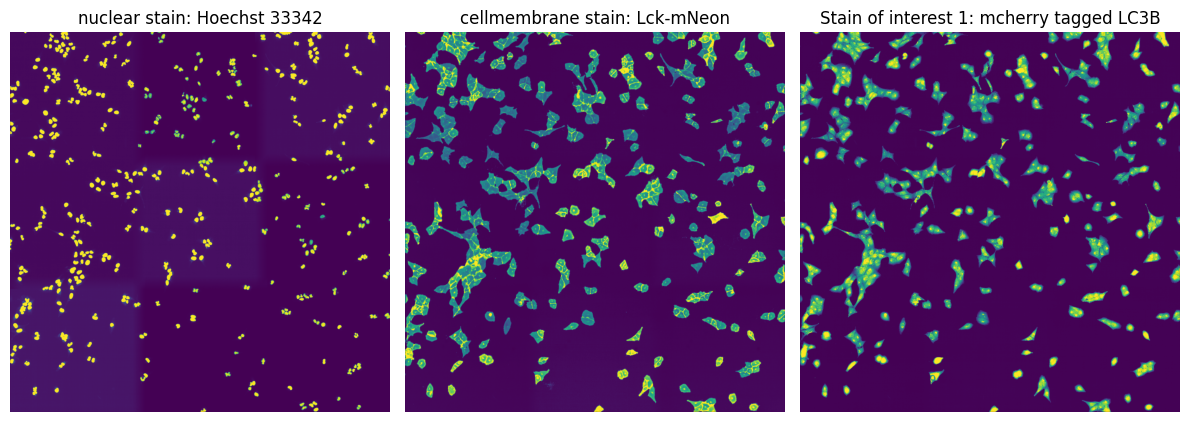

In [24]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")
axs[0].set_title("nuclear stain: Hoechst 33342")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")
axs[1].set_title("cellmembrane stain: Lck-mNeon")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")
axs[2].set_title("Stain of interest 1: mcherry tagged LC3B")

fig.tight_layout()

Alternatively, you can also visualize the input images as well as all other objects saved in a spatialdata object

In [25]:
project.view_sdata()

## Generating a Segmentation

scPortrait has different segmentation workflows between which you can choose. If none of them fit your needs you can also easily write your own. 

Here we will demonstrate the CPU based classical segmentation method that was also utilized in the manuscript. 

We define the segmentation method to be used when we initialize the project. In this case we used the `WGASegmentation` method. The `ShardedWGASegmentation` works very similarily but allows you to process several image chunks in parallel for more efficient computation on large input images.

By specifying `debug = True` we can see intermediate output results from the segmentation. 

The `WGASegmentation` method relies on parameters specified in the `config.yml` we loaded when initializing our project.

        WGASegmentation:
        cache: "."
        chunk_size: 50 # chunk size for chunked HDF5 storage
        lower_quantile_normalization:   0.001
        upper_quantile_normalization:   0.999
        median_filter_size:   4 # Size in pixels
        nucleus_segmentation:
            lower_quantile_normalization:   0.01 # quantile normalization of dapi channel before local tresholding Strong normalization (0.05,0.95) can help with nuclear speckles.
            upper_quantile_normalization:   0.99 # quantile normalization of dapi channel before local tresholding.Strong normalization (0.05,0.95) can help with nuclear speckles.
            median_block: 41 # Size of pixel disk used for median, should be uneven
            median_step: 4
            threshold: 0.2 # threshold above local median for nuclear segmentation
            min_distance: 8 # minimum distance between two nucleis in pixel
            peak_footprint: 7 # 
            speckle_kernel: 9 # Erosion followed by Dilation to remove speckels, size in pixels, should be uneven
            dilation: 0 # final dilation of pixel mask       
            min_size: 200 # minimum nucleus area in pixel
            max_size: 1000 # maximum nucleus area in pixel
            contact_filter: 0.5 # minimum nucleus contact with background
        cytosol_segmentation:
            threshold: 0.05 # treshold above which cytosol is detected
            lower_quantile_normalization: 0.01
            upper_quantile_normalization: 0.99
            erosion: 2 # erosion and dilation are used for speckle removal and shrinking / dilation
            dilation: 7 # for no change in size choose erosion = dilation, for larger cells increase the mask erosion
            min_clip: 0
            max_clip: 0.2
            min_size: 200
            max_size: 6000
        filter_masks_size: True

By passing the parameter ``debug = True`` we tell scPortrait to also generate intermediate outputs which we can look at to see the different segmentation steps. It is only recommended to do this for debugging or visualization purposes as it will utilize more memory and be slower.

For the ``WGASegmentation`` method the intermediate outputs that are displayed are the following: 

1. percentile normalized input images for each of the three channels (3 images)
2. median normalized input images (this slightl smooths the images for a better segmentation result) (3 images)
3. histogram showing the intensity distribution for nuclear and cytosolic channel (2 plots)
4. generated mask after applying nuclear thresholding
5. nuclear thresholding mask with calculated centers for each detected nucleus
6. fast marching map with nuclei centers indicated in red
7. segmented individual nuclei (2 different visualizations)
8. starting nucleus mask for filtering
9. histrogram showing size distribution of segmented nuclei
10. segmentation mask with too small nuclei shown in red
11. segmentation mask with too large nuclei shown in red
12. WGA thresholding mask
13. WGA potential map
14. WGA fast marching results
15. Watershed results with nuclear centers shown in red
15. WGA mask
16. Cytosol size distribution
10. cytosol mask with too small cells shown in red
11. cytosol mask with too large cells shown in red


2025-01-27 15:14:10.261 python[17435:29712084] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-27 15:14:10.261 python[17435:29712084] +[IMKInputSession subclass]: chose IMKInputSession_Modern


[27/01/2025 15:14:10] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/tutorials/WGASegmentation_o2zkynfc for WGASegmentation
[27/01/2025 15:14:10] Normalization of the input image will be performed.
[27/01/2025 15:14:11] Normalizing each channel to the same range
[27/01/2025 15:14:16] Performing median filtering on input image
[27/01/2025 15:14:36] Percentile normalization of nucleus input image to range 0.01, 0.99
[27/01/2025 15:14:36] Normalizing each channel to the same range
[27/01/2025 15:14:39] Using local thresholding with a threshold of 0.2 to calculate nucleus mask.


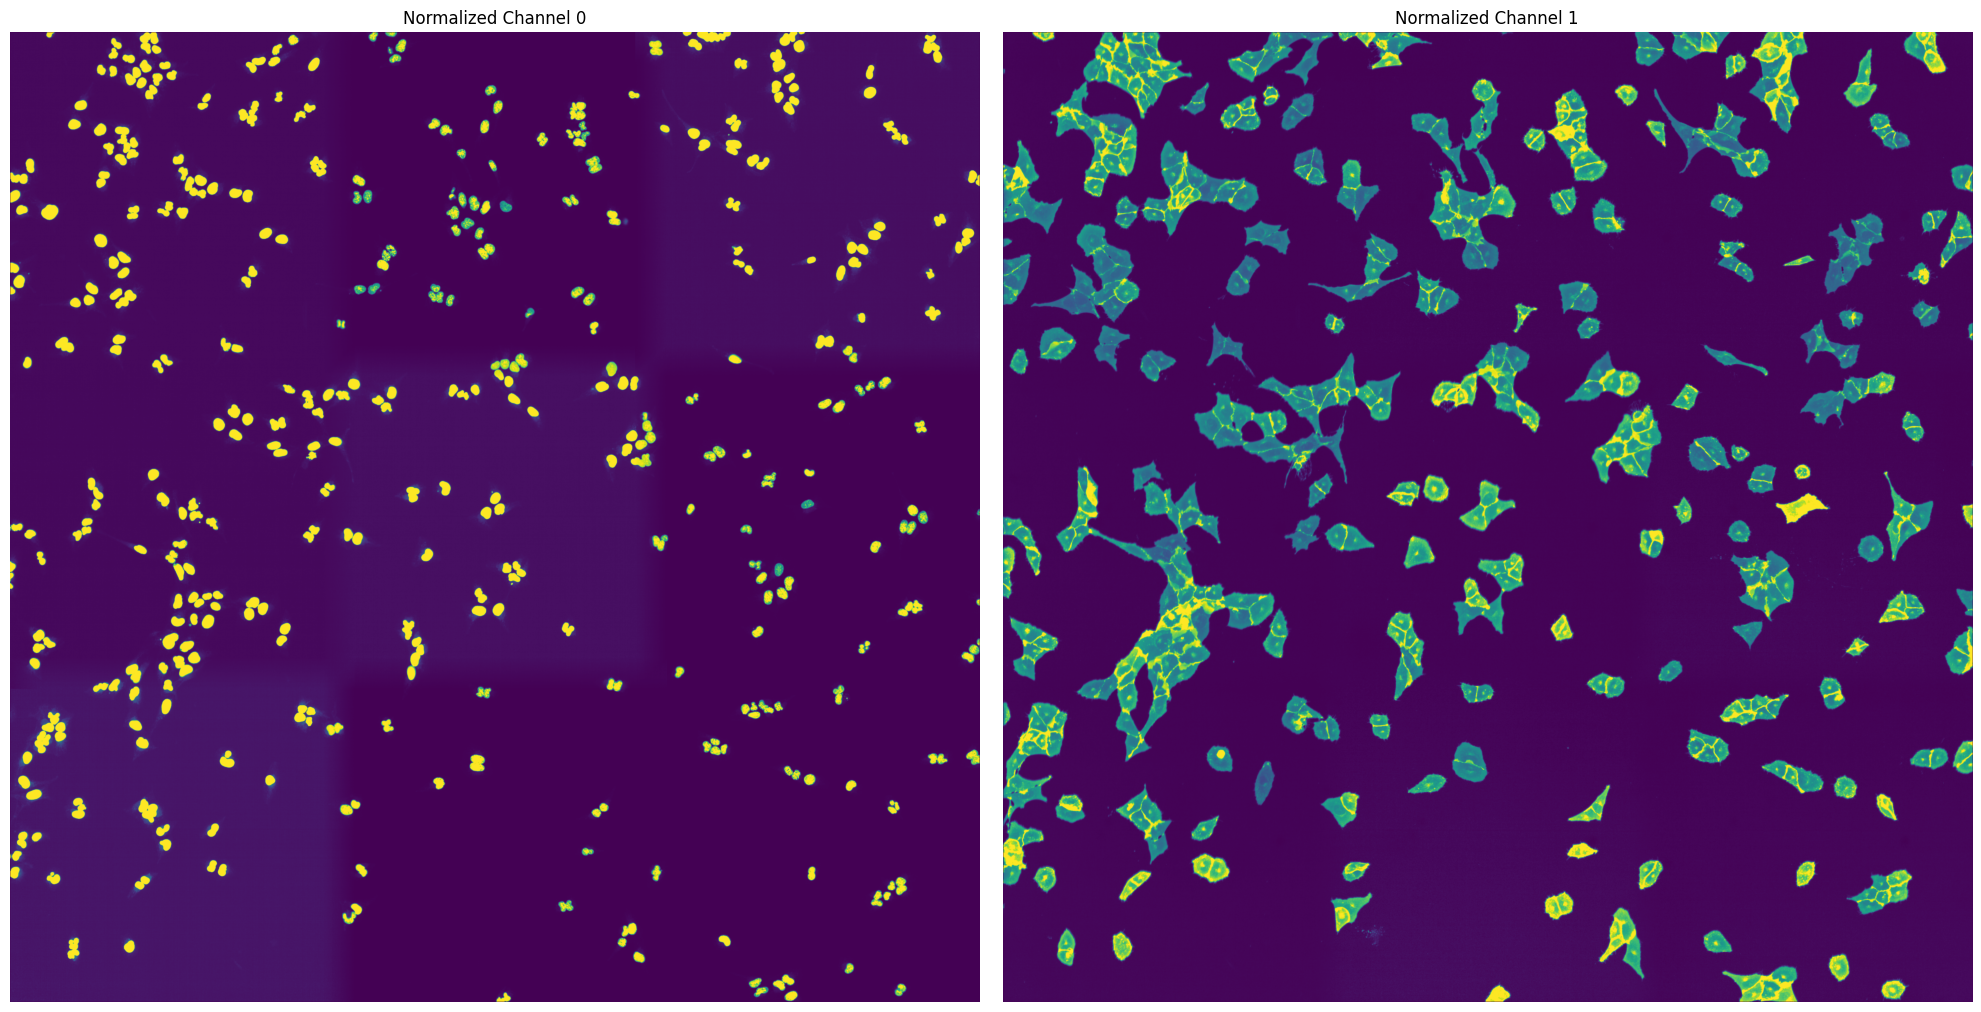

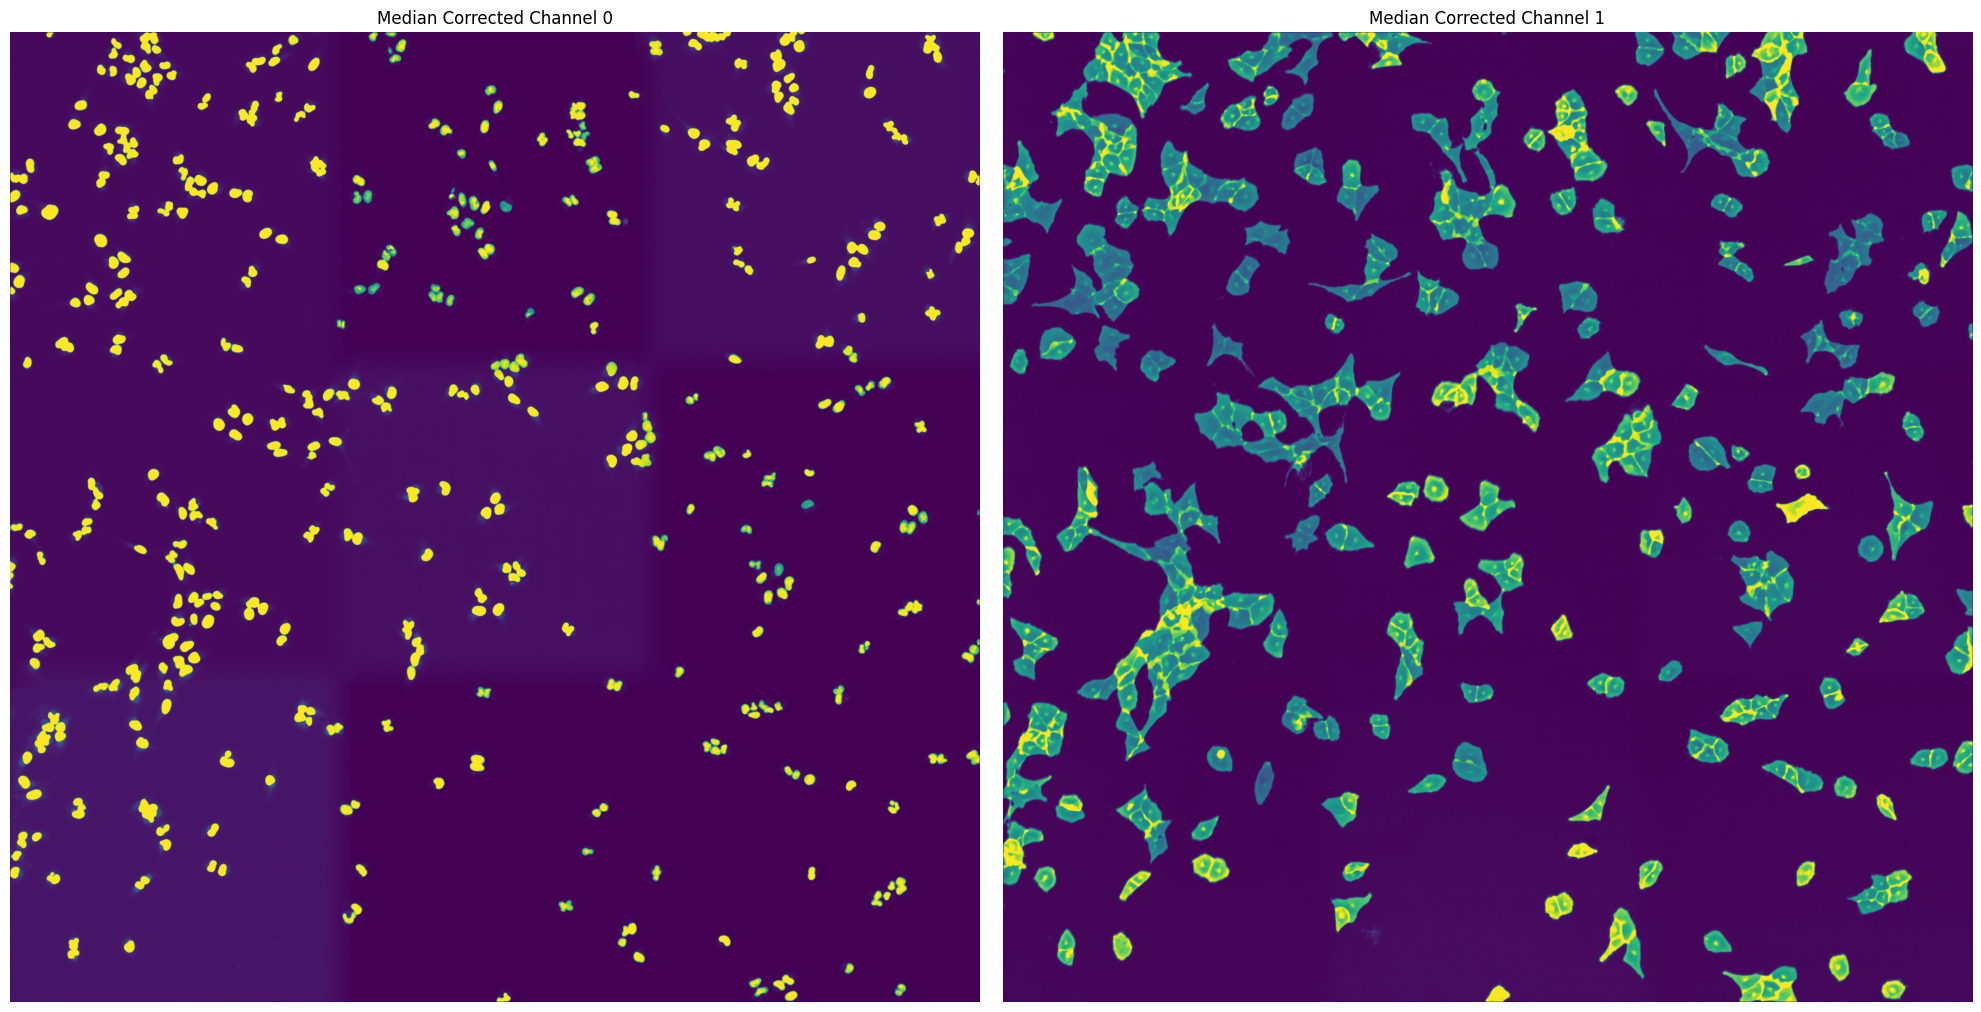

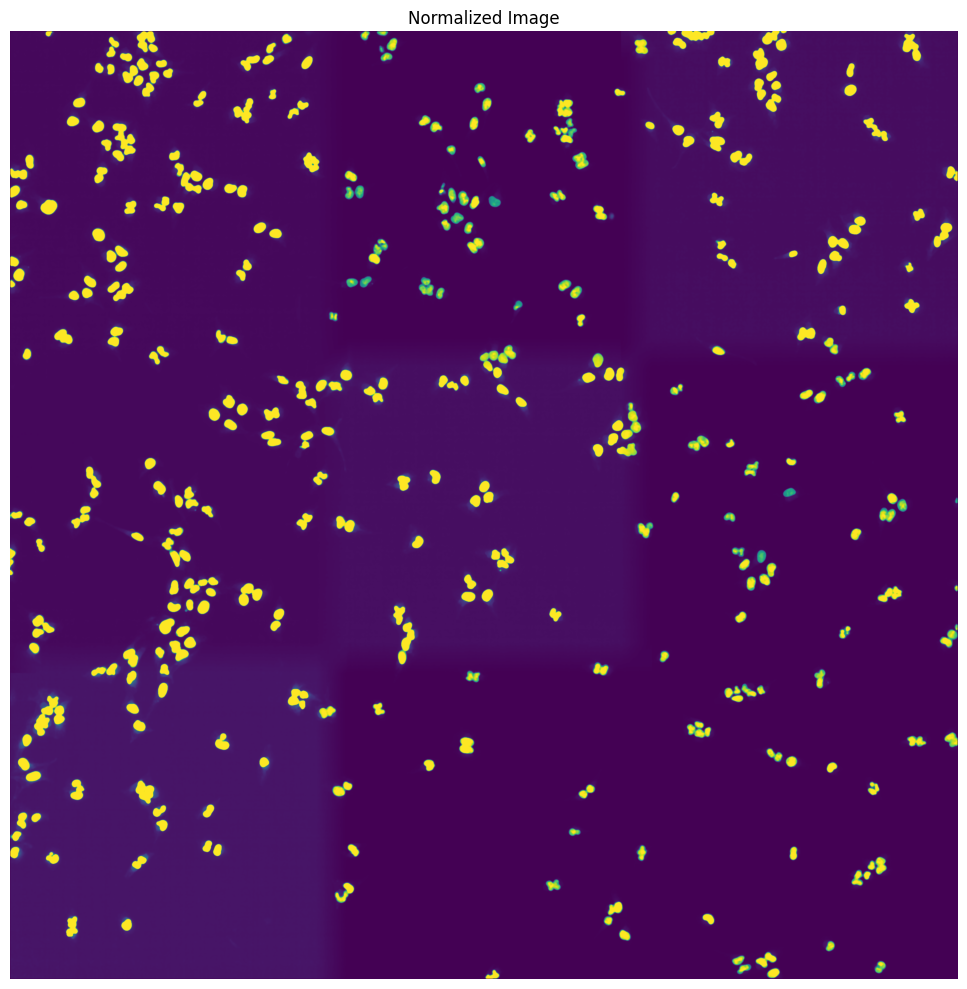

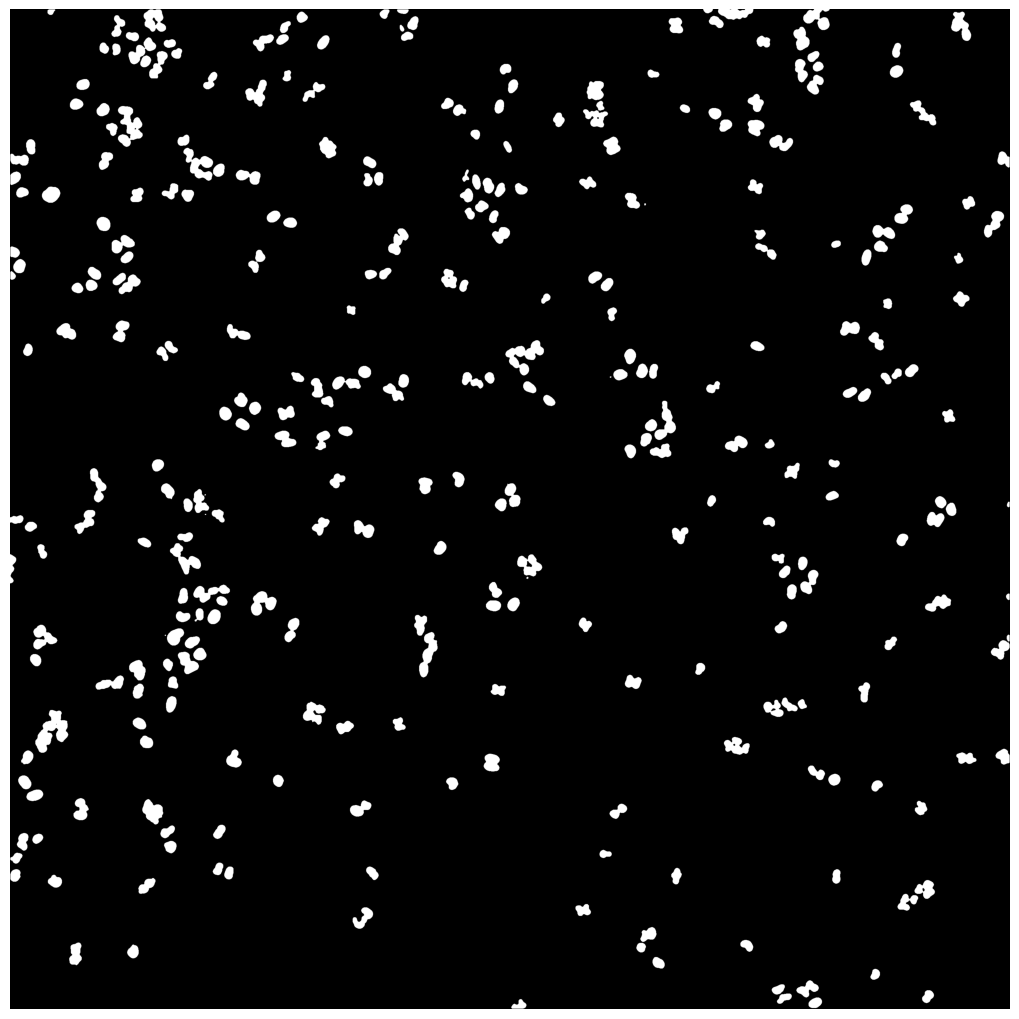

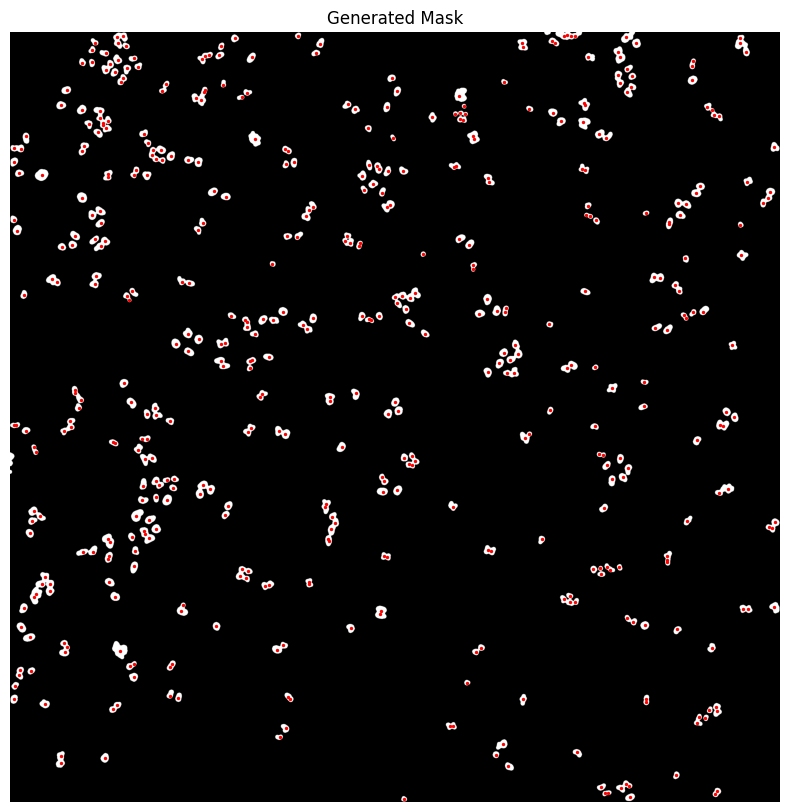

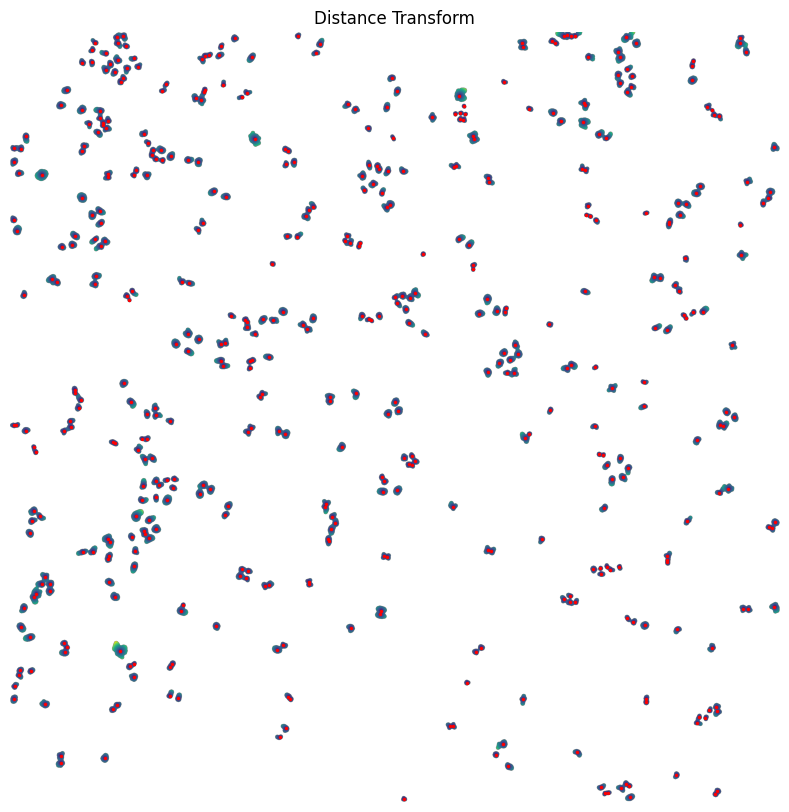

[27/01/2025 15:14:55] Performing filtering of nucleus with specified thresholds [200, 1000] from config file.
[27/01/2025 15:14:55] Removed 47 nuclei as they fell outside of the threshold range [200, 1000].
[27/01/2025 15:14:56] Total time to perform nucleus size filtering: 1.1202349662780762 seconds


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[27/01/2025 15:14:58] Filtered out 6 nuclei due to contact filtering.
[27/01/2025 15:14:58] Normalizing each channel to the same range
[27/01/2025 15:15:00] Cytosol Potential Mask generated.
[27/01/2025 15:15:02] Performing filtering of cytosol with specified thresholds [200, 6000] from config file.


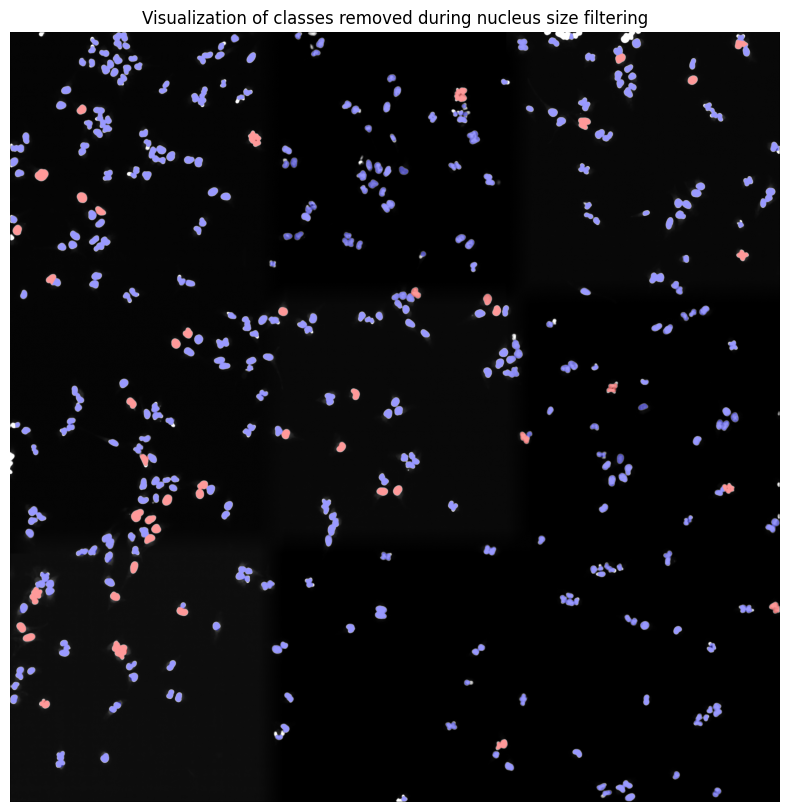

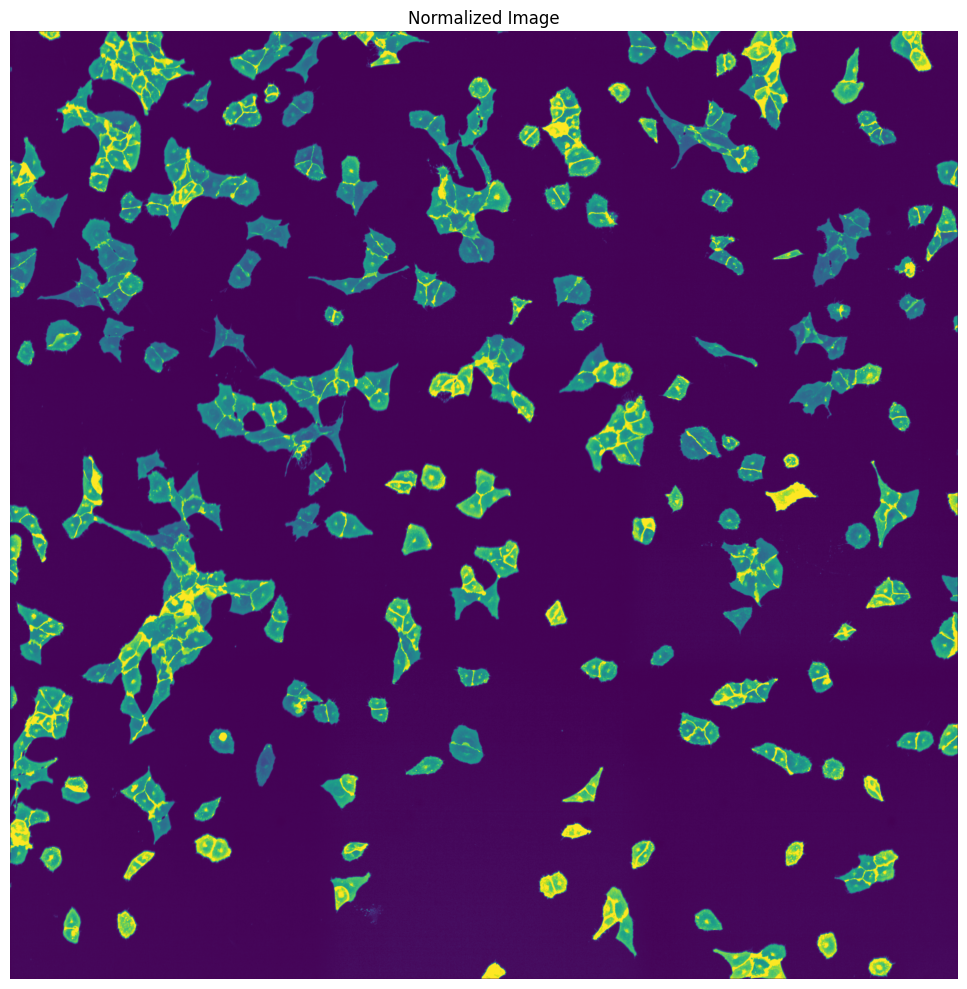

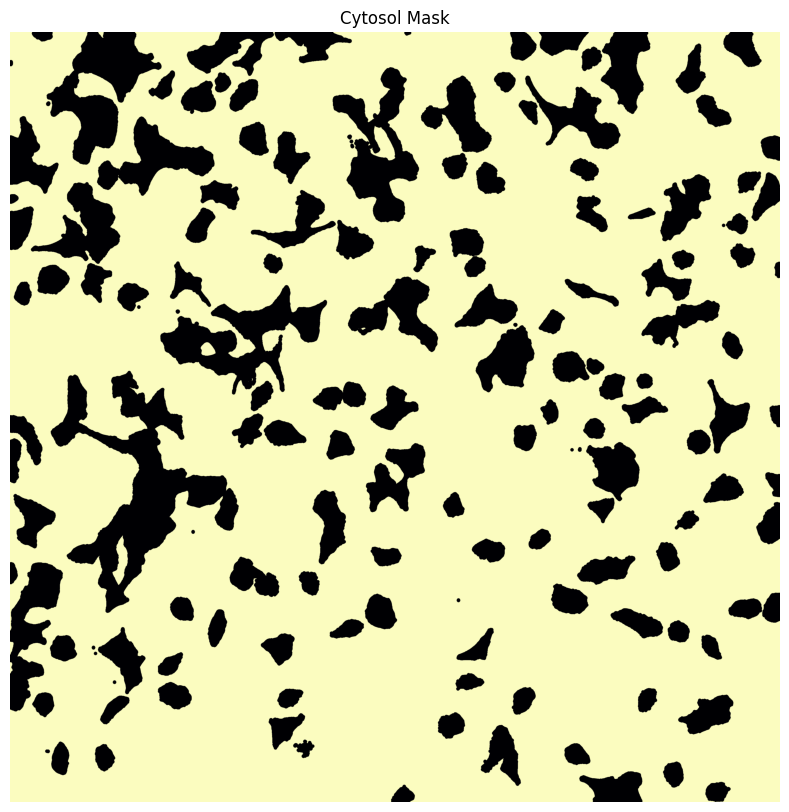

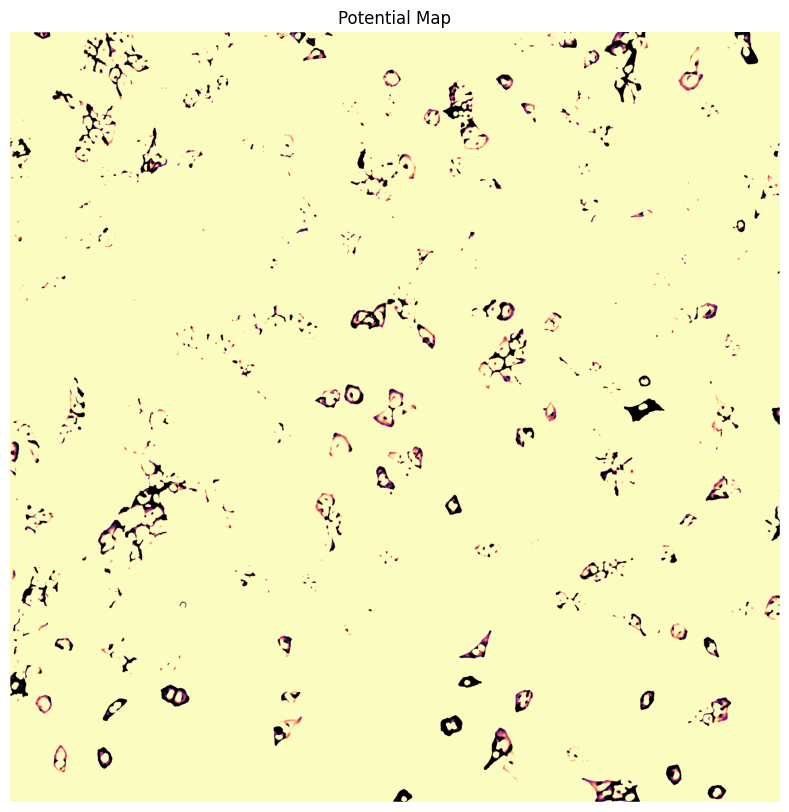

[27/01/2025 15:15:05] Removed 78 nuclei as they fell outside of the threshold range [200, 6000].
[27/01/2025 15:15:06] Total time to perform cytosol size filtering: 3.839001178741455 seconds
[27/01/2025 15:15:08] Segmentation seg_all_nucleus written to sdata object.
[27/01/2025 15:15:08] Segmentation seg_all_cytosol written to sdata object.
[27/01/2025 15:15:08] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/tutorials/WGASegmentation_o2zkynfc'>


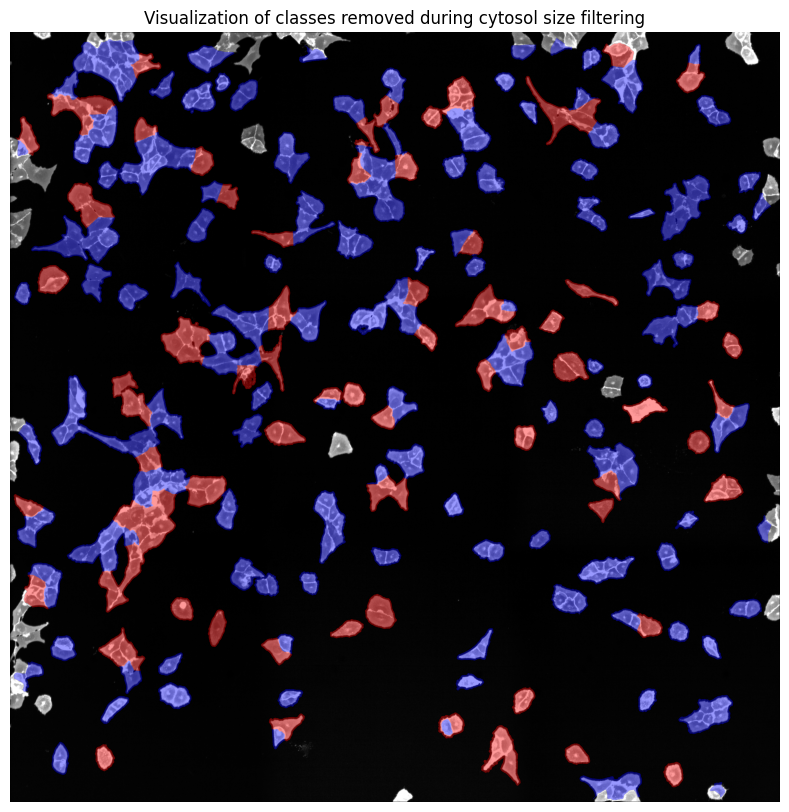

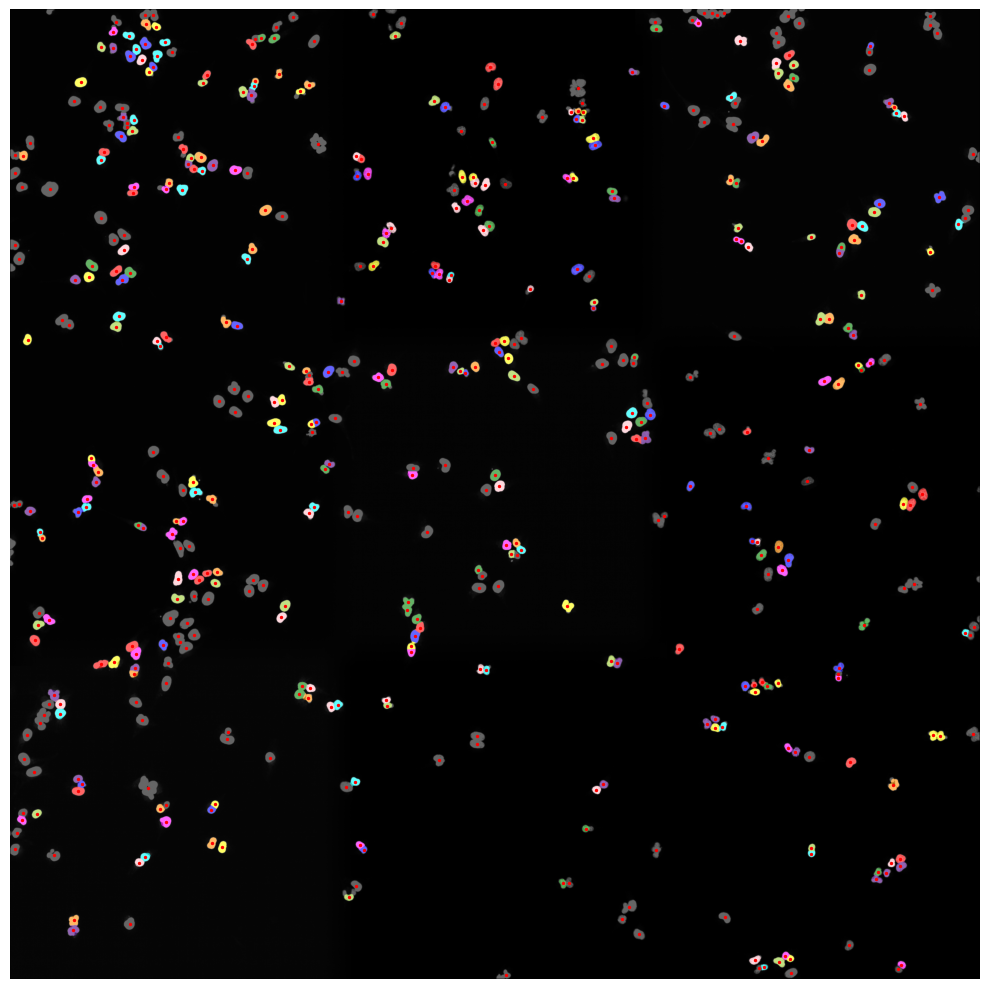

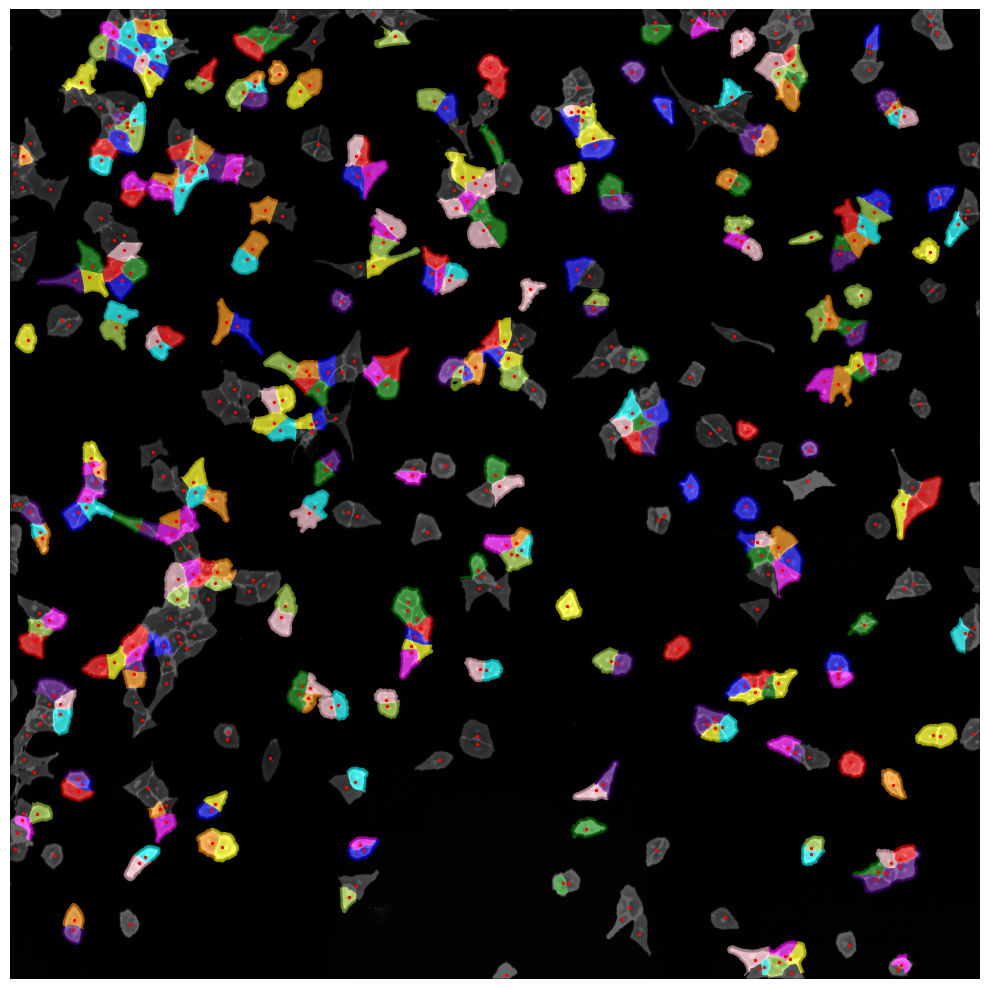

In [8]:
project.segment()

### Inspecting Segmentation Results

The Segmentation Results are written to a hdf5 file called `segmentation.h5` located in the segmentation directory of our scPortrait project.

The file contains two datasets: `channels` and `labels`. Channels contains the input images and `labels` the generated segmentation masks.

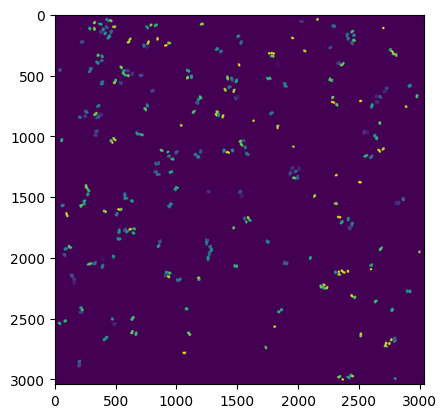

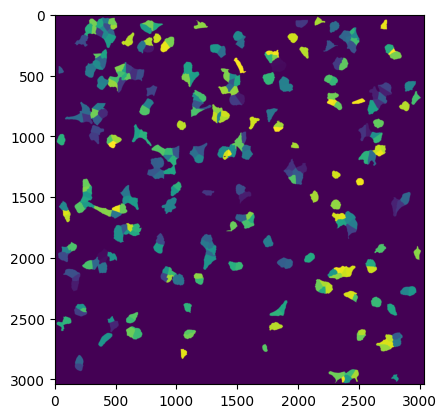

In [9]:
plt.figure()
plt.imshow(project.sdata.labels["seg_all_nucleus"])
plt.figure()
plt.imshow(project.sdata.labels["seg_all_cytosol"])

If we look at the `labels` dataset we can see that it contains a numpy array containing two segmentation masks: the nuclear segmentation and the cytosol segmentation generated by our chosen segmentation method.

Each segmentation mask is an array where each pixel is assigned either to background (`0`) or to a specific cell (`cellid: whole number`).

If we zoom in on the corner of the segmentation mask of a nucleus the numpy array would look like this:

[[395 395 395 395 395 395   0   0   0   0]
 [395 395 395 395 395 395 395 395   0   0]
 [395 395 395 395 395 395 395 395 395   0]
 [395 395 395 395 395 395 395 395 395   0]
 [395 395 395 395 395 395 395 395 395 395]
 [395 395 395 395 395 395 395 395 395 395]
 [395 395 395 395 395 395 395 395 395 395]
 [395 395 395 395 395 395 395 395 395 395]
 [395 395 395 395 395 395 395 395 395 395]
 [395 395 395 395 395 395 395 395 395 395]
 [395 395 395 395 395 395 395 395 395 395]
 [395 395 395 395 395 395 395 395 395   0]
 [395 395 395 395 395 395 395 395 395   0]
 [395 395 395 395 395 395 395 395   0   0]
 [395 395 395 395 395 395   0   0   0   0]
 [395 395 395 395   0   0   0   0   0   0]
 [395 395   0   0   0   0   0   0   0   0]
 [395   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


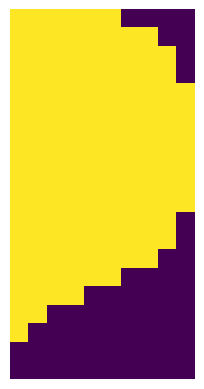

In [10]:
plt.imshow(project.sdata.labels["seg_all_nucleus"][230:250, 945:955])
plt.axis("off")
print(project.sdata.labels["seg_all_nucleus"][230:250, 945:955].data.compute())

## Extracting single cell images

Once we have generated a segmentation mask, the next step is to extract single-cell images of segmented cells in the dataset.

Like during the segmentation there are several extraction methods to choose from. For regular scPortrait projects we need the `HDF5CellExtraction` method. This will extract single-cell images for all cells segmentated in the dataset and write them to a hdf5 file.

The parameters with which `HDF5CellExtraction` will run are again specified in the `config.yml` file.

                HDF5CellExtraction:
                    compression: True
                    threads: 80 # threads used in multithreading
                    image_size: 128 # image size in pixel
                    cache: "."

[27/01/2025 15:15:12] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_0ofv8_y3 for HDF5CellExtraction
[27/01/2025 15:15:12] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/extraction/data
[27/01/2025 15:15:12] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/extraction/data
[27/01/2025 15:15:12] Found 2 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_nucleus', 'seg_all_cytosol']
[27/01/2025 15:15:12] Using seg_all_nucleus as the main segmentation mask to determine cell centers.
[27/01/2025 15:15:13] Points centers_cells written to sdata object.
[27/01/2025 15:15:13] Extraction Details:
[27/01/2025 15:15:13] --------------------------------
[27/01/2025 15:15:13] Number of input image

Processing cell batches: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]

[27/01/2025 15:15:19] Finished extraction in 5.64 seconds (58.13 cells / second)
[27/01/2025 15:15:19] Transferring results to final HDF5 data container.
[27/01/2025 15:15:19] number of cells too close to image edges to extract: 14
[27/01/2025 15:15:19] A total of 14 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/extraction/removed_classes.csv.


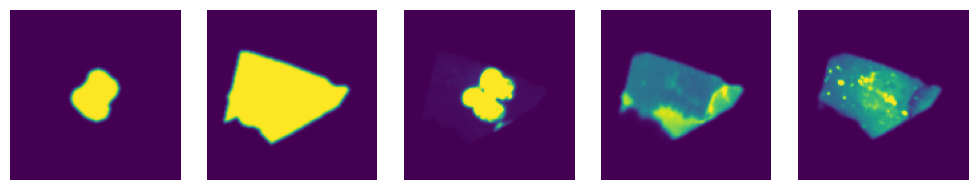

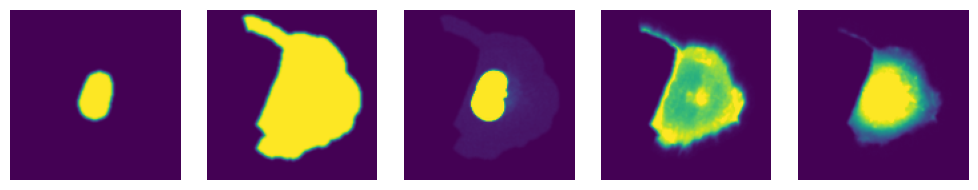

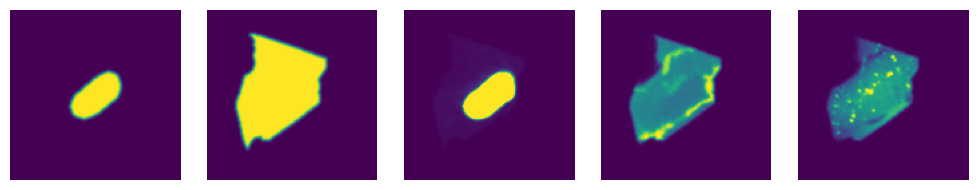

[27/01/2025 15:15:19] Transferring extracted single cells to .hdf5
[27/01/2025 15:15:19] single-cell index created.
[27/01/2025 15:15:19] single-cell data created
[27/01/2025 15:15:19] single-cell index labelled created.
[27/01/2025 15:15:19] channel information created.
[27/01/2025 15:15:19] Benchmarking times saved to file.
[27/01/2025 15:15:19] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_0ofv8_y3'>


In [11]:
project.extract()

### Look at extracted single cell images

The extracted single-cell images are written to a h5py file `single_cells.h5` located under `extraction\data` within the project folder.

The file contains two datasets: `single_cell_data` and `single_cell_index`. `single_cell_data` contains the extracted single cell images while `single_cell_index` contains the cell id of the extracted cell at that location.

In [12]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    print(hf.keys())

<KeysViewHDF5 ['channel_information', 'n_masks', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']>


So if we want to look at the nth cell in the dataset we can first check which cellid was assigned to this cell by looking at the nth entry in the `single_cell_index` dataset and then get the extracted single-cell images from the `single_cell_data` dataset.

The extracted single-cell images represent the following information in this order:  
<ol>
1. nucleus mask<br>
                2. cytosol mask  <br>
                3. nucleus channel <br> 
                4. cytosol channel <br> 
                5. other channels<br>
</ol> 

Here we will demonstrate with the 10th cell in the dataset.

cell id:  [10 43]


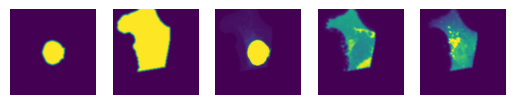

In [13]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print("cell id: ", index[10])

    image = images[10]

    fig, axs = plt.subplots(1, 5)

    for i, _img in enumerate(image):
        axs[i].imshow(_img)
        axs[i].axis("off")

## Classification of extracted single cells

Next we can apply a pretained model to classify our cells within the scPortrait project. 

Within the `config.yml` we specify which model should be used for inference and we can give it a name. 

                MLClusterClassifier:
                    channel_selection: 4
                    batch_size: 900
                    dataloader_worker_number: 10
                    network: "autophagy_classifier2"
                    classifier_architecture: "VGG2_old"
                    label: "Autophagy_15h_classifier2.1"
                    inference_device: "cpu"

Here e.g. we are using a pretrained model included within the scPortrait library `autophagy_classifier2.1` and are naming the results from this model `Autophagy_15h_classifier2.1`. 

Model overview:

<img src="../../../docs/pages/images/classifying_autophagy.png" alt="autophagy classification with example cells" width="800"/>


The inference results will be written to a new folder generated under `featurization` with this name. 

If we want to use a model we trained ourselves that is not yet included within the scPortrait library we can simply replace the network name in the config with the path to the checkpoint file generated by pytorch.


In [14]:
project.featurize()

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/extraction/data/single_cells.h5
[27/01/2025 15:15:20] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/tutorials/MLClusterClassifier_riyx8qpa for MLClusterClassifier
[27/01/2025 15:15:20] Started MLClusterClassifier classification.
[27/01/2025 15:15:20] Overwrite flag is set, deleting existing directory for featurization results.
[27/01/2025 15:15:20] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/featurization/complete_Autophagy_15h_classifier2_1
[27/01/2025 15:15:20] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[27/01/2025 15:15:20] Model class defined as <class 'scportrait.tools.ml.plmodels.MultilabelSupervisedModel'>


Lightning automatically upgraded your loaded checkpoint from v1.5.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../src/scportrait/scportrait_data/vgg_autophagy_classifier/VGG2_autophagy_classifier2.1.cpkt`


[27/01/2025 15:15:20] Model assigned to featurization function.
[27/01/2025 15:15:20] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/extraction/data/single_cells.h5
[27/01/2025 15:15:20] Expected image size is set to [128, 128]. Resizing images to this size.
[27/01/2025 15:15:20] Dataloader generated with a batchsize of 900 and 10 workers. Dataloader contains 1 entries.
[27/01/2025 15:15:20] Starting inference for model encoder forward
[27/01/2025 15:15:20] Started processing of 1 batches.
[27/01/2025 15:15:22] finished processing.
[27/01/2025 15:15:22] Results saved to file: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/featurization/complete_Autophagy_15h_classifier2_1/inference_forward.csv
[27/01/2025 15:15:22] Table MLClusterClassifier_Autophagy_15h_classifier2_1_forward_nucleus written to sdata object.
[27/01/2025 15:15:22] Table MLClusterClassifier_Au

### Looking at the generated results

The results are written to a csv file which we can load with pandas.

scPortrait writes the softmax results directly to csv as `ln()` for better precision. To transform these numbers back to the range between 0 and 1 we first need to apply the `np.exp` function.

In [15]:
results = pd.read_csv(
    f"{project_location}/featurization/complete_Autophagy_15h_classifier2_1/inference_forward.csv", index_col=None
)
results.result_0 = np.exp(results.result_0)
results.result_1 = np.exp(results.result_1)

results

result_0  result_1  label  cell_id
0    0.017384  0.982615      0       12
1    0.000517  0.999483      0       13
2    0.806387  0.193613      0       15
3    0.146037  0.853963      0       18
4    0.896932  0.103068      0       33
..        ...       ...    ...      ...
309  0.023494  0.976506      0      491
310  0.000234  0.999766      0      493
311  0.000014  0.999986      0      494
312  0.988722  0.011278      0      495
313  0.679858  0.320142      0      496

[314 rows x 4 columns]

Depending on the model we used what `result_0` and `result_1` represent will vary. Here we used a binary classification model were class 1 was cells deficient in autophagy. So `result_1` indicates the probability score that a cell has the label "autophagy off". `results_0` is simply `1 - result_1`


If we look at the distribution in our dataset we can see that almost all cells are classified as "autophagy defective". Since the input images were from unstimulated wt cells this matches to our expectation.

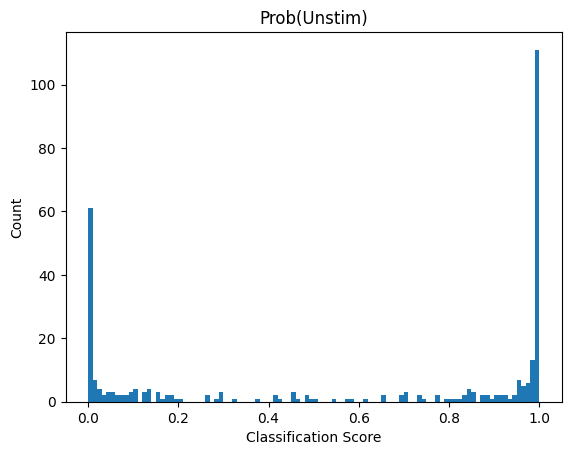

In [16]:
plt.hist(results.result_1, bins=100)
plt.title("Prob(Unstim)")
plt.xlabel("Classification Score")
plt.ylabel("Count");

## Exporting Cutting contours for excision on a Leica LMD7

scPortrait directly interfaces with our other open-source python library [py-lmd](https://github.com/MannLabs/py-lmd) to easily select and export cells for excision on a Leica LMD microscope. 

Of note: this will require that the cells have been plates on a LMD compatible surface (like a PPS slide). scPortrait can of course also simply be used for data analysis procedures, then ignore this last step.

First we will select the cells we wish to excise based on their classification score. Here we have chosen a threadhold >= 0.99999 for bin1 and a threshold <= 0.9 for bin2. 

In [17]:
cell_ids_bin1 = results[results.result_1 >= 0.99999].cell_id.tolist()
cell_ids_bin2 = results[results.result_1 <= 0.9].cell_id.tolist()

print("number of cells to excise:", len(cell_ids_bin1) + len(cell_ids_bin2))

number of cells to excise: 177


The cells can then be allocated into different wells.

In [18]:
cells_to_select = [
    {"name": "bin1", "classes": list(cell_ids_bin1[0:5]), "well": "A1"},
    {"name": "bin2", "classes": list(cell_ids_bin2[0:5]), "well": "B1"},
]

In addition to defining which cells we want to excise, we also need to pass the location of the calibration crosses so that we can transfer the image coordinate system into a cutting coordinate system. You can read up on this [here](https://mannlabs.github.io/py-lmd/html/pages/segmentation_loader.html#different-coordinate-systems).

To obtain the coordinates of your reference points simply open your stitched image in e.g. FIJI and navigate to the location of your reference points. Then write out the coordinates for each point.

In [19]:
marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])

As with the previous methods, additional parameters can be passed to the selection function via the `config.yml` file which adapts the behaviour of how cutting shapes are generated. You can read up more on this [here](https://mannlabs.github.io/py-lmd/html/pages/segmentation_loader.html#overview-of-configuration).

                LMDSelection:
                    processes: 20

                    # defines the channel used for generating cutting masks
                    # segmentation.hdf5 => labels => segmentation_channel
                    # When using WGA segmentation:
                    #    0 corresponds to nuclear masks
                    #    1 corresponds to cytosolic masks.
                    segmentation_channel: 0

                    # dilation of the cutting mask in pixel
                    shape_dilation: 16

                    # number of datapoints which are averaged for smoothing
                    # the number of datapoints over an distance of n pixel is 2*n
                    smoothing_filter_size: 25

                    # fold reduction of datapoints for compression
                    poly_compression_factor: 30
                    
                    # can be "none", "greedy", or "hilbert"
                    path_optimization: "hilbert"
                    
                    # number of nearest neighbours for optimized greedy search
                    greedy_k: 15
                    
                    # hilbert curve order
                    hilbert_p: 7



[27/01/2025 15:15:23] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_w4u104bo for LMDSelection
[27/01/2025 15:15:23] Selection process started.


Processing cell batches: 100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


[27/01/2025 15:15:31] Temporary directory not found, skipping cleanup
[27/01/2025 15:15:31] Coordinate lookup index calculation took 8.281137332785875 seconds.
No configuration for shape_erosion found, parameter will be set to 0
No configuration for binary_smoothing found, parameter will be set to 3
No configuration for convolution_smoothing found, parameter will be set to 15
No configuration for rdp_epsilon found, parameter will be set to 0.1
No configuration for xml_decimal_transform found, parameter will be set to 100
No configuration for distance_heuristic found, parameter will be set to 300
No configuration for join_intersecting found, parameter will be set to True
Path optimizer used for XML generation: hilbert
cell set 0 passed sanity check
cell set 1 passed sanity check
Loading coordinates from external source
Processing cell sets in parallel
collecting cell sets:   0%|          | 0/2 [00:00<?, ?it/s]Convert label format into coordinate format
Conversion finished, performing sa

creating shapes:   0%|          | 0/5 [00:00<?, ?it/s]

0 shapes that were intersecting were found and merged.
0 shapes that were intersecting were found and merged.


calculating polygons: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Current path length: 8,926.31 units
Current path length: 5,278.80 units
Optimized path length: 4,332.93 units
Optimization factor: 2.1x
Optimized path length: 3,169.40 units
Optimization factor: 1.7x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets: 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


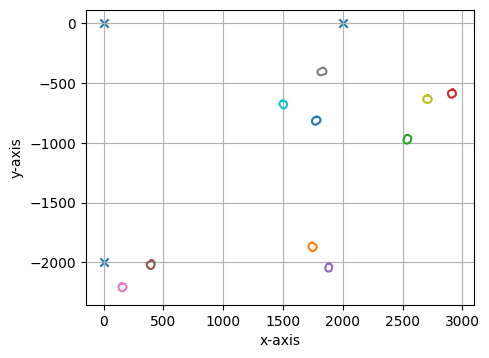

===== Collection Stats =====
Number of shapes: 10
Number of vertices: 692
Mean vertices: 69
Min vertices: 63
5% percentile vertices: 63
Median vertices: 69
95% percentile vertices: 76
Max vertices: 76
[0 0]
[      0 -200000]
[200000      0]
[27/01/2025 15:15:39] Saved output at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_WGA/selection/bin1_bin2.xml
[27/01/2025 15:15:39] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_w4u104bo'>


In [20]:
project.select(cells_to_select, calibration_marker)